# Pipeline for the anomaly detection based on 2 local datasets using SST-detector

In [1]:
import sys
sys.path.append(r'...\Fedot.Industrial')

import requests
import numpy as np 
import pandas as pd

from io import StringIO
from cases.anomaly_detection.WSSAlgorithms import WindowSizeSelection
from cases.anomaly_detection.SSTdetector import SingularSpectrumTransformation

import matplotlib.pyplot as plt

In [2]:

from tsad.evaluating.evaluating import evaluating

# Data Loading

In [3]:
def dataframe_expirement(i):
    if i == 1:
        url = "https://storage.yandexcloud.net/cloud-files-public/dataframe.csv" 
        dataframe = pd.read_csv(StringIO(requests.get(url).content.decode('utf-8')), sep='|')
        dataframe_columns = dataframe.columns 
        first_label_list = dataframe[dataframe_columns[0]].unique() 
        dataframe_aa564g = dataframe[dataframe[dataframe_columns[0]] == first_label_list[0]]
        dataframe_aa564g_first = dataframe_aa564g.drop(axis=1, labels=(dataframe_aa564g.columns[0])) \
            .drop(axis=1, labels=(dataframe_aa564g.columns[1]))[['m', 'v/v', 'v/v.1',
                                                                 'uR/h', 'ohmm', 'ohmm.1', 'ohmm.2', 'ohmm.3', 'ohmm.5',
                                                                 'ohmm.6',
                                                                 'unitless', 'unitless.1']].reset_index(drop=True)
        dataframe_edited_ = dataframe_aa564g_first.loc[dataframe_aa564g_first['unitless.1'] >= 0] \
            .loc[dataframe_aa564g_first['unitless'] >= 0].loc[dataframe_aa564g_first['ohmm'] >= 0] \
            .loc[dataframe_aa564g_first['ohmm.1'] >= 0].loc[dataframe_aa564g_first['ohmm.2'] >= 0] \
            .loc[dataframe_aa564g_first['ohmm.3'] >= 0].loc[dataframe_aa564g_first['ohmm.5'] >= 0] \
            .loc[dataframe_aa564g_first['ohmm.6'] >= 0].loc[dataframe_aa564g_first['uR/h'] >= 0] \
            .loc[dataframe_aa564g_first['v/v.1'] >= 0].loc[dataframe_aa564g_first['v/v'] >= 0] \
            .reset_index(drop=True)
    else:
        url = "https://storage.yandexcloud.net/cloud-files-public/noname_ECG_2022.csv" 
        dataframe_edited_ = pd.read_csv(StringIO(requests.get(url).content.decode('utf-8')), sep=',')
    return dataframe_edited_

In [4]:
ts_data_1, ts_data_2 = dataframe_expirement(1), dataframe_expirement(0).iloc[2500:].reset_index().drop(labels='index',axis=1)

# Data description and visualization

In [5]:
from scipy.signal import find_peaks

In [6]:
def plot_data_scores_and_selected_window(ts, score_list, window_size_selected):
    f, ax = plt.subplots(2, 1, figsize=(30, 20))
    ax[0].plot(ts)
    ax[0].vlines(x=window_size_selected, ymin=min(ts), ymax=max(ts),
        linestyle = ':',
        linewidth = 6,
        color = 'darkblue')
    ax[0].set_title("ts")
    ax[1].plot(score_list, "r")
    ax[1].set_title("score")
    f.show()

In [7]:
# dataset characteristics printing
print(f'A number of datasets: {2}\n')
print(f'Shape of the well dataset: {ts_data_1.shape}\n')
print(f'Shape of the medical dataset: {ts_data_2.shape}\n')
cp_1 = []
temp_value_second = 0
for i in range(len(ts_data_1)):
    temp_value = ts_data_1['unitless'][i]
    if temp_value != temp_value_second:
        cp_1.append(1)
    else:
        cp_1.append(0)
    temp_value_second = temp_value
cp_1[0] = 0
cp_2 = []
peaks, _ = find_peaks(ts_data_2['EcgWaveform'], distance=250)
for i in range(len(ts_data_2)):
    if i not in peaks:
        cp_2.append(0)
    else:
        cp_2.append(1)
ts_data_1['change_points'] = cp_1
ts_data_2['change_points'] = cp_2
print(f'A number of datasets: {2}\n')
print(f'Shape of the well dataset: {ts_data_1.shape}\n')
print(f'Shape of the medical dataset: {ts_data_2.shape}\n')
n_cp_1 = cp_1.count(1)
n_cp_2 = cp_2.count(1)
print(f'A number of changepoints in the well dataset: {n_cp_1}\n')
print(f'A number of changepoints in the medical dataset: {n_cp_2}\n')
print(f'Head of the well dataset:')
display(ts_data_1.head())
print(f'Head of the well dataset:')
display(ts_data_2.head())

A number of datasets: 2

Shape of the well dataset: (8754, 12)

Shape of the medical dataset: (17500, 2)

A number of datasets: 2

Shape of the well dataset: (8754, 13)

Shape of the medical dataset: (17500, 3)

A number of changepoints in the well dataset: 52

A number of changepoints in the medical dataset: 37

Head of the well dataset:


,m,v/v,v/v.1,uR/h,ohmm,ohmm.1,ohmm.2,ohmm.3,ohmm.5,ohmm.6,unitless,unitless.1,change_points
0,3185.5,0.960549,0.901756,56.50,38.11802,46.61687,26.52874,36.00038,0.126035,0.126063,5,1,0
1,3185.6,0.960549,0.924199,55.10,38.51000,41.08000,28.23000,30.61000,0.126035,0.126062,5,1,0
2,3185.7,0.960549,0.920993,55.30,38.49500,40.22613,27.25827,29.11342,0.126035,0.126062,5,1,0
3,3185.8,0.960549,0.917787,55.50,38.48000,39.39000,26.32000,27.69000,0.126035,0.126062,5,1,0
4,3185.9,0.960549,0.922435,55.21,37.06394,38.07816,28.97599,30.48858,0.126035,0.126061,5,1,0


Head of the well dataset:


,Time,EcgWaveform,change_points
0,04/08/2022 08:38:37.946,2450,0
1,04/08/2022 08:38:37.947,2447,0
2,04/08/2022 08:38:37.948,2445,0
3,04/08/2022 08:38:37.949,2442,0
4,04/08/2022 08:38:37.950,2440,0


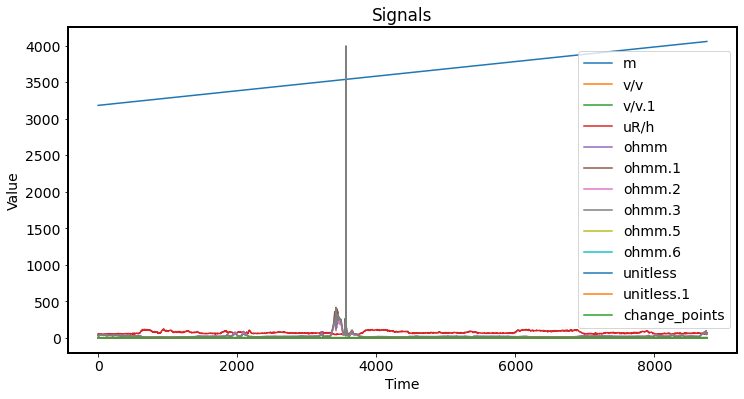

In [8]:
# well dataset visualizing
ts_data_1.plot(figsize=(12,6))
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Signals')
plt.show()

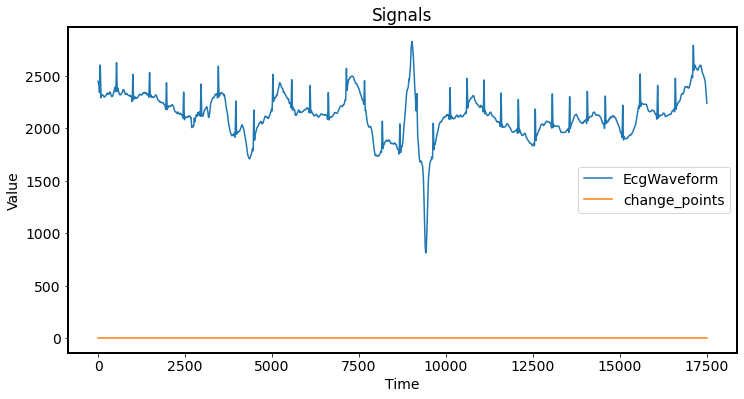

In [9]:
# medical dataset visualizing
ts_data_2.plot(figsize=(12,6))
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Signals')
plt.show()

# Labels

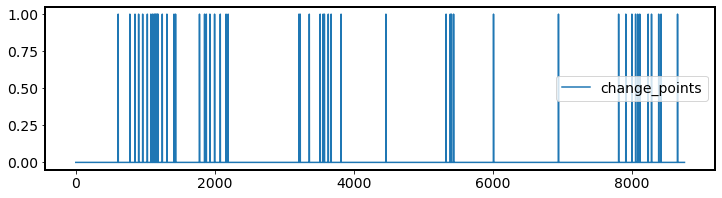

In [10]:
# plotting the labels both for outlier and changepoint detection problems
ts_data_1.change_points.plot(figsize=(12,3))
plt.legend()
plt.show()

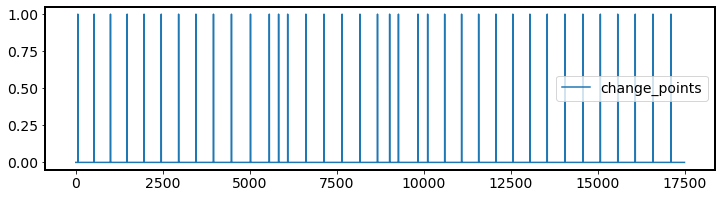

In [11]:
# plotting the labels both for outlier and changepoint detection problems
ts_data_2.change_points.plot(figsize=(12,3))
plt.legend()
plt.show()

# Method applying

In [18]:
def window_size_selection(ts):
    scorer = WindowSizeSelection(time_series = ts, wss_algorithm = 'highest_autocorrelation', window_max = 500)
    window_size_selected, score = scorer.runner_wss()
    if window_size_selected%2 != 0:
        window_size_selected = window_size_selected + 1
    return window_size_selected

def change_point_detection(ts, lag, dynamic_mode, quantile_rate):
    ts_window_length = window_size_selection(ts)
    trajectory_window_length = window_size_selection(ts[:ts_window_length])
    scorer = SingularSpectrumTransformation(time_series = np.array(ts),
                                            ts_window_length = ts_window_length,
                                            lag = lag,
                                            trajectory_window_length = trajectory_window_length)
    score = scorer.score_offline(dynamic_mode=dynamic_mode)
    return score

In [19]:
list_of_df = [ts_data_1, ts_data_2]

In [20]:
Q = 0.999 # quantile for upper control limit (UCL) selection

predicted_cp = []
for i in range(len(list_of_df)):
    if i == 0:
        df = list_of_df[0]
        ts = list(df['uR/h'])
    else:
        df = list_of_df[1]
        ts = list(df['EcgWaveform'])
    
    result = change_point_detection(ts, lag=10, dynamic_mode=True, quantile_rate=Q)
    df['results'] = result + [0]
    predicted_cp.append(df['results'])

In [21]:
true_cp = [list_of_df[0].change_points, list_of_df[1].change_points]

# Results

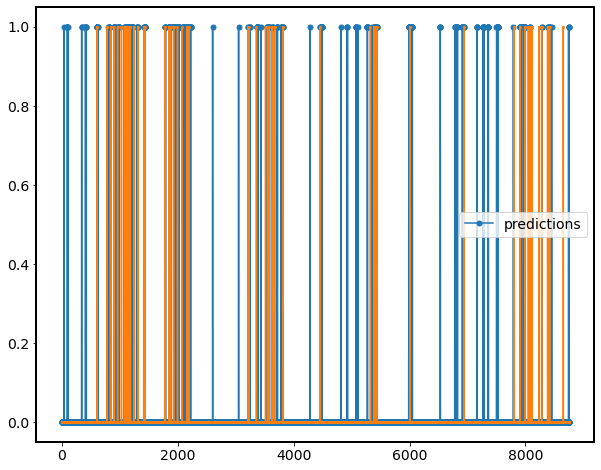

In [22]:
plt.plot(predicted_cp[0],label='predictions', marker='o', markersize=5)
plt.plot(true_cp[0], marker='o', markersize=2)
plt.legend();

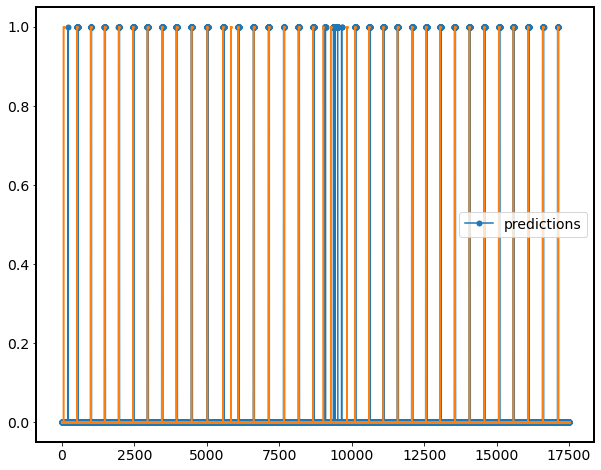

In [23]:
plt.plot(predicted_cp[1],label='predictions', marker='o', markersize=5)
plt.plot(true_cp[1], marker='o', markersize=2)
plt.legend();

# Metrics calculation

In [24]:
from datetime import datetime, timedelta

In [25]:
t_0 = np.arange(len(true_cp[0])).astype('datetime64[s]')
t_1 = np.arange(len(true_cp[1])).astype('datetime64[s]')

In [26]:
df_0 = pd.DataFrame(index=t_0, columns=['predicted_cp'])
df_0['predicted_cp'] = np.array(predicted_cp[0])
df_0['true_cp'] = np.array(true_cp[0])

In [27]:
df_1 = pd.DataFrame(index=t_1, columns=['predicted_cp'])
df_1['predicted_cp'] = np.array(predicted_cp[1])
df_1['true_cp'] = np.array(true_cp[1])

In [28]:
# nab metric calculation
nab = evaluating(df_0['true_cp'], df_0['predicted_cp'], metric='nab', numenta_time='30 sec')

Intersection of scoring windows(Timestamp('1970-01-01 00:18:00'), Timestamp('1970-01-01 00:17:54'))
Intersection of scoring windows(Timestamp('1970-01-01 00:18:24'), Timestamp('1970-01-01 00:18:16'))
Intersection of scoring windows(Timestamp('1970-01-01 00:18:46'), Timestamp('1970-01-01 00:18:31'))
Intersection of scoring windows(Timestamp('1970-01-01 00:19:01'), Timestamp('1970-01-01 00:18:45'))
Intersection of scoring windows(Timestamp('1970-01-01 00:19:15'), Timestamp('1970-01-01 00:19:01'))
Intersection of scoring windows(Timestamp('1970-01-01 00:19:31'), Timestamp('1970-01-01 00:19:13'))
Intersection of scoring windows(Timestamp('1970-01-01 00:23:33'), Timestamp('1970-01-01 00:23:25'))
Intersection of scoring windows(Timestamp('1970-01-01 00:30:52'), Timestamp('1970-01-01 00:30:47'))
Intersection of scoring windows(Timestamp('1970-01-01 00:36:01'), Timestamp('1970-01-01 00:36:01'))
Intersection of scoring windows(Timestamp('1970-01-01 00:53:29'), Timestamp('1970-01-01 00:53:17'))


In [33]:
# average detection delay metric calculation
add = evaluating(df_0['true_cp'], df_0['predicted_cp'], metric='average_time', numenta_time='30 sec')

Intersection of scoring windows(Timestamp('1970-01-01 00:18:00'), Timestamp('1970-01-01 00:17:54'))
Intersection of scoring windows(Timestamp('1970-01-01 00:18:24'), Timestamp('1970-01-01 00:18:16'))
Intersection of scoring windows(Timestamp('1970-01-01 00:18:46'), Timestamp('1970-01-01 00:18:31'))
Intersection of scoring windows(Timestamp('1970-01-01 00:19:01'), Timestamp('1970-01-01 00:18:45'))
Intersection of scoring windows(Timestamp('1970-01-01 00:19:15'), Timestamp('1970-01-01 00:19:01'))
Intersection of scoring windows(Timestamp('1970-01-01 00:19:31'), Timestamp('1970-01-01 00:19:13'))
Intersection of scoring windows(Timestamp('1970-01-01 00:23:33'), Timestamp('1970-01-01 00:23:25'))
Intersection of scoring windows(Timestamp('1970-01-01 00:30:52'), Timestamp('1970-01-01 00:30:47'))
Intersection of scoring windows(Timestamp('1970-01-01 00:36:01'), Timestamp('1970-01-01 00:36:01'))
Intersection of scoring windows(Timestamp('1970-01-01 00:53:29'), Timestamp('1970-01-01 00:53:17'))


In [30]:
# nab metric calculation
nab = evaluating(df_1['true_cp'], df_1['predicted_cp'], metric='nab', numenta_time='30 sec')

Standart  -  -24.19
LowFP  -  -103.05
LowFN  -  12.7


In [31]:
# average detection delay metric calculation
add = evaluating(df_1['true_cp'], df_1['predicted_cp'], metric='average_time', numenta_time='30 sec')

Amount of true anomalies 37
A number of missed CPs = 5
A number of FPs = 507
Average time 0 days 00:00:10.500000
